In [58]:
%matplotlib inline

from datetime import datetime, timedelta
import os
import pandas as pd
import numpy as np
import plotly
import plotly.offline as offline
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
import matplotlib.dates as mdates
import math
from urllib.request import urlopen
import json
import copy
from scipy.stats.stats import pearsonr
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

local_covid_19_data = '/Users/davidmorton/Documents/COVID-19/'
local_directory = os.getcwd()

field_test_availability = 'Tests Per 100,000 People'
field_rolling_average = '7-Day Confirmed Rolling Average'

!git -C $local_covid_19_data pull

remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 157 (delta 110), reused 116 (delta 109), pack-reused 40
Receiving objects: 100% (157/157), 645.59 KiB | 3.75 MiB/s, done.
Resolving deltas: 100% (111/111), completed with 16 local objects.
From https://github.com/CSSEGISandData/COVID-19
   43a9ba95..8561285a  master     -> origin/master
   1a52a356..9201d5de  web-data   -> origin/web-data
Updating 43a9ba95..8561285a
Fast-forward
 .../csse_covid_19_daily_reports/05-31-2020.csv     | 3527 +++++++++++
 .../csse_covid_19_daily_reports_us/05-31-2020.csv  |   59 +
 .../time_series_covid19_confirmed_US.csv           | 6524 ++++++++++----------
 .../time_series_covid19_confirmed_global.csv       |  534 +-
 .../time_series_covid19_deaths_US.csv              | 6524 ++++++++++----------
 .../time_series_covid19_deaths_global.csv          |  534 +-
 .../time_series_covid19_recovered_global.csv       |

In [59]:
def get_single_date_data(date):
    datestr = date.strftime('%m-%d-%Y')
    filename = local_covid_19_data + 'csse_covid_19_data/csse_covid_19_daily_reports_us/' + datestr + '.csv'
    result = pd.read_csv(filename)
    result['Date'] = date
    return result

def get_daily_report_data():
    start_date_for_daily_data = datetime(2020, 4, 12)
    current_date = start_date_for_daily_data

    yesterday = (datetime.now() + timedelta(days = -1))
    #yesterday = datetime.now()
    lastdate = yesterday.strftime('%m-%d-%Y')
    
    series = pd.DataFrame()

    while True:
        series = series.append(get_single_date_data(current_date))
        current_date = current_date + timedelta(days = 1)
        if current_date > yesterday:
            break
    
    
    return series

def smooth_bad_cumulative_values(series, columns):
    
    for columnname in columns:
        states = np.sort(series['Province_State'].unique())

        for state in states:
            stateseries = series[series['Province_State'] == state]

            cumulative = stateseries[columnname].cummax()

            series.loc[(series['Province_State'] == state) & (stateseries[columnname] < cumulative), columnname] = np.nan

            interpolation = series[series['Province_State'] == state][columnname].interpolate()

            series.loc[series['Province_State'] == state, columnname] = interpolation

    return series;

def drop_instances_where_reported_equals_confirmed(series):
    series.loc[series['NewConfirmedVsTests'] > 0.5] = np.nan 
    return series

def clean_daily_report_data(series, rollingrate):
    series.reset_index(inplace=True)
    series = series.dropna(subset=['People_Tested', 'Confirmed']).copy()
    
    series = smooth_bad_cumulative_values(series, ['People_Tested', 'Confirmed'])
    
    series = series.set_index(['Province_State', 'Date'])
    
    series['NewConfirmed'] = series.sort_values(by=['Date']).groupby(['Province_State'])['Confirmed'].transform(pd.Series.diff).fillna(0)
    series['NewTests'] = series.sort_values(by=['Date']).groupby(['Province_State'])['People_Tested'].transform(pd.Series.diff).fillna(0)
    series['NewConfirmedVsTests'] = series['NewConfirmed'].div(series['NewTests']).dropna()
    series[field_rolling_average] = pd.DataFrame(series.groupby('Province_State', as_index=False)['NewConfirmed'].rolling(rollingrate).sum()).reset_index().set_index(['Province_State', 'Date'])['NewConfirmed'].div(pd.DataFrame(series.groupby('Province_State', as_index=False)['NewTests'].rolling(rollingrate).sum()).reset_index().set_index(['Province_State', 'Date'])['NewTests'])
    series[field_test_availability] = pd.DataFrame(series.groupby('Province_State', as_index=False)['Testing_Rate'].rolling(rollingrate).mean()).reset_index().set_index(['Province_State', 'Date'])['Testing_Rate']
    series['RollingStd'] = pd.DataFrame(series.groupby('Province_State', as_index=False)['NewConfirmedVsTests'].rolling(rollingrate).std()).reset_index().set_index(['Province_State', 'Date'])['NewConfirmedVsTests']
    series['RollingCV'] = series['RollingStd'].div(series[field_rolling_average])
    
    series = series.replace([np.inf, -np.inf], np.nan).dropna(subset=['NewConfirmedVsTests'])
    
    series = series.reset_index()
     
    return series;

def get_timeseries(rollingrate, states_to_drop):
    original_series = get_daily_report_data();    
    series = original_series.copy()
    series = clean_daily_report_data(series, rollingrate)
    series = series[~series["Province_State"].isin(states_to_drop)]
    return series

def output_rolling_confirmed_chart(state, ax):
    
    statedata = series[series['Province_State'] == state].copy().dropna(subset=[field_rolling_average, 'Date'])
    latestdate = statedata['Date'].max()
    earliestdate = statedata['Date'].min()
    
    maxvalue = statedata[field_rolling_average].max() + 0.01
    
    color = "Blue"
    yes = (datetime.now() + timedelta(days = -1)).date()
    if (latestdate < yes):
        color = "Gray"
        
    ax = statedata.plot.line(
        x='Date', 
        y=field_rolling_average, 
        xlim=(earliestdate, latestdate), 
        ylim=(0, maxvalue), 
        ax=ax, 
        legend=False, 
        color=color
    )
    
    ax = statedata.plot.scatter(
        x='Date', 
        y='NewConfirmedVsTests', 
        ax=ax, 
        legend=False, 
        color="Red"
    )
    
    ax.set_ylabel('Percentage Confirmed (7-Day Rolling Avg)')
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    
    ax.yaxis.grid()
    
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    day_formatter = mdates.DateFormatter('%d')
    days = mdates.DayLocator()
    
    #ax.xaxis.set_major_locator(months)
    #ax.xaxis.set_minor_formatter(day_formatter)
    #ax.xaxis.set_major_formatter(mtick.FuncFormatter(format_date))
    #ax.format_xdata = lambda x: 'BLAH' #('A%d' % x) if x.weekday() == 6 else '';


    ax.set_title(state + ' ' + "{0:.2%} (upd {1:%b %d})".format(statedata[-1:][field_rolling_average].iloc[0], latestdate))
    
def format_date(x, pos=None):
    thisind = np.clip(int(x + 0.5), 0, N - 1)
    return date[thisind].strftime('%Y-%m-%d')


def get_axes(rows, cols):
    fig, axes = plt.subplots(rows, 
                         cols, 
                         figsize=(18, rows*6), 
                         gridspec_kw={'hspace': 0.5, 'wspace': 0.3}, 
                         facecolor='#fbfbfb')
    if (rows * cols) > 1:
        return fig, axes.flatten()
    else:
        return fig, [axes]

def get_latest_data():
    yesterdaydata = series.merge(series.groupby('Province_State')['Date'].max().reset_index(), on=["Province_State", "Date"])

    yesterdaydata.index = yesterdaydata['Province_State']
    raw_state_abbreviations = pd.read_csv(local_directory + '/states.csv')
    raw_state_abbreviations.index = raw_state_abbreviations['State']

    yesterdaydata['StateId'] = raw_state_abbreviations['Abbreviation']

    yesterdaydata = yesterdaydata.dropna(subset=['StateId'], axis=0)
 
    yesterdaydata = yesterdaydata[yesterdaydata[field_rolling_average] < 0.5]
    return yesterdaydata


def make_usa_choropleth(series, locations, title, colorbartitle, colorspectrum):
    
    bins = pd.qcut(series, q=8, retbins=True)[1]
    bins = (bins - bins.min()) / (bins.max() - bins.min())

    colorscale = list(zip(bins, colorspectrum))

    fig = go.Figure(
        data=go.Choropleth(
            locations=locations,
            z = series,
            locationmode = 'USA-states',
            colorscale = colorscale,
            colorbar_title = colorbartitle
        )
    )

    fig.update_layout(
        title_text = title,
        geo_scope='usa', # limite map scope to USA
    )

    fig.show()
    
def plot_bar(series, x, y):
    ax = series.sort_values(by=y).plot.bar(x = x, y=y, figsize=(15,8))
    ax.yaxis.grid()
    plt.show(ax)


    

# USA Data

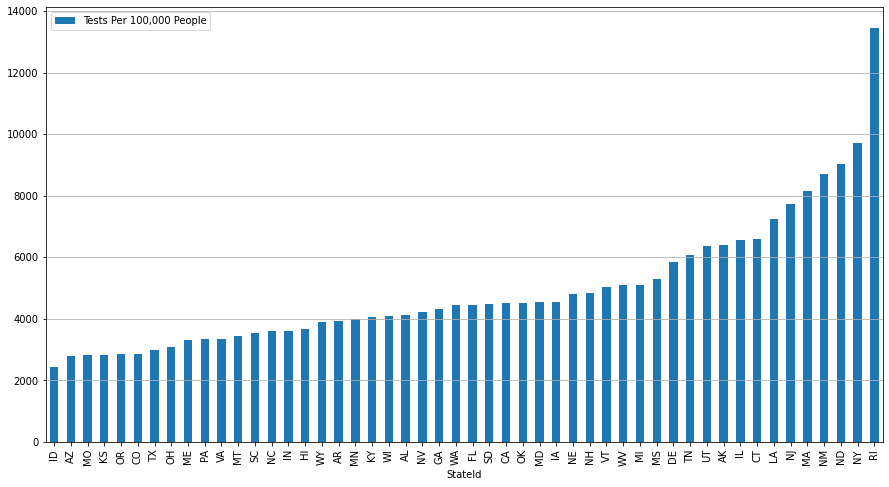

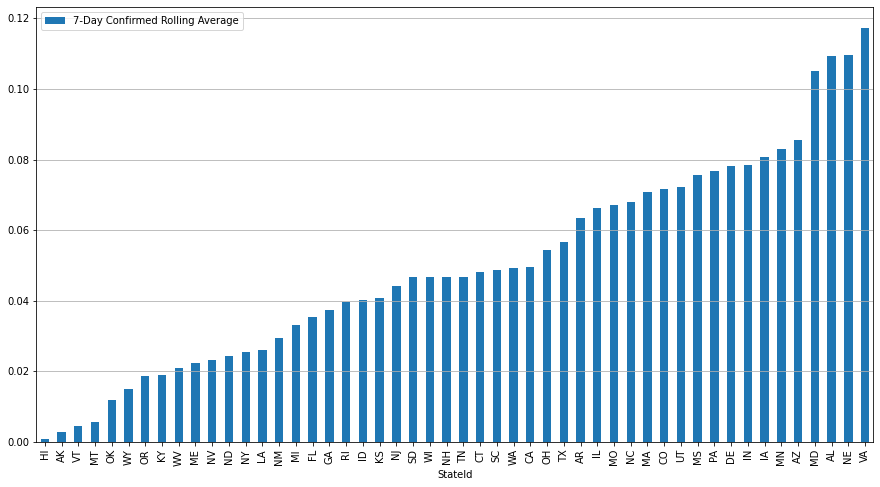

## 7-Day Rolling Averages of Confirmed Percentage for all US States & Territories

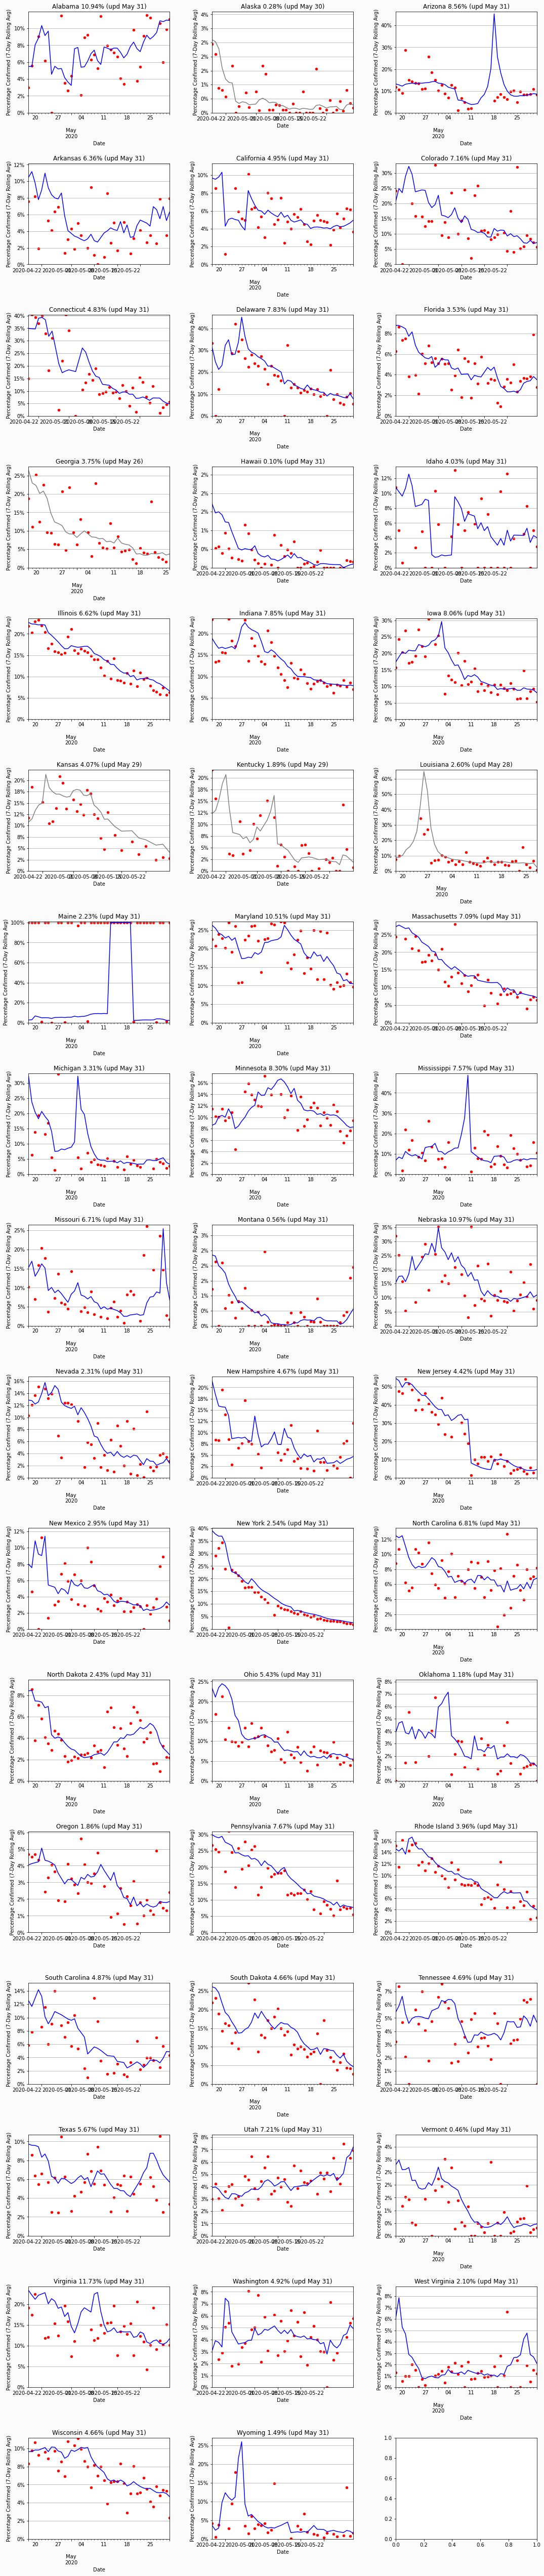

In [60]:
rollingrate = 7
states_to_drop = ['Puerto Rico', 'American Samoa', 'Guam', 'District of Columbia', 'Northern Mariana Islands', 'Virgin Islands']

series = get_timeseries(rollingrate, states_to_drop)

latestdata = get_latest_data();

printmd('# USA Data')

make_usa_choropleth(
    series=np.around(latestdata[field_rolling_average].astype(float) * 100, decimals=2), 
    locations=latestdata["StateId"], 
    title="Percent Positive in USA", 
    colorbartitle="% Pos", 
    colorspectrum=px.colors.sequential.YlOrRd
)

make_usa_choropleth(
    series=np.around(latestdata[field_test_availability].astype(float), decimals=2), 
    locations=latestdata["StateId"], 
    title="Test Availability in USA", 
    colorbartitle="Rate per 100,000 ppl", 
    colorspectrum=px.colors.sequential.Blues
)

plot_bar(latestdata, "StateId", field_test_availability)
plot_bar(latestdata, "StateId", field_rolling_average)

printmd('## 7-Day Rolling Averages of Confirmed Percentage for all US States & Territories')

states = np.sort(series.dropna(subset=[field_rolling_average])['Province_State'].unique())
numrows = math.ceil(len(states) / 3)
fig, axes = get_axes(numrows, 3);

for i, state in enumerate(states):
    output_rolling_confirmed_chart(state, axes[i])

plt.show()

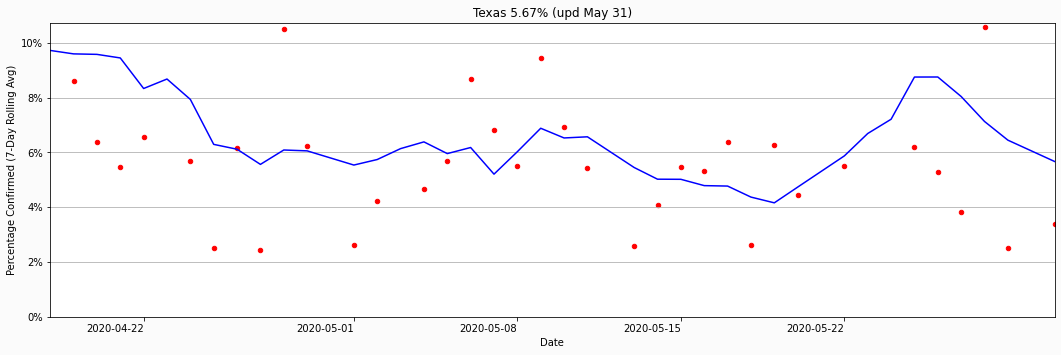

In [61]:
def county_choropleth(selected_state, drop_states, normalize_colorscale, colorscale_to_use):
    yesterday = (datetime.now() + timedelta(days = -1))
    lastdate = yesterday.strftime('%m-%d-%Y')
    fipsData = pd.read_csv(local_covid_19_data + 'csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv')
    filename = local_covid_19_data + 'csse_covid_19_data/csse_covid_19_daily_reports/' + lastdate + '.csv'
    result = pd.read_csv(filename)

    result = result.dropna(subset=['FIPS', 'Active']).set_index("FIPS")

    result = fipsData.merge(result, on="FIPS", how="left").dropna(subset=["FIPS", "Lat_x", "Long__x", "Admin2_x"]);

    result = result.reset_index()[["FIPS", "Population", "Active", "Province_State_x", "Admin2_x"]]
    result = result.rename(columns={"Province_State_x": "Province_State", "Admin2_x": "Admin2"})
    result = result.fillna(value={"Active": 10**-10});

    result = result[~result['Province_State'].isin(drop_states)]

    map_data = result

    badfips = [80008, 80013, 80015, 80017, 80026, 80040, 80047, 90049, 90001, 90002, 90004, 90005, 90006, 90008, 90009, 90010, 90012, 90013, 90015, 90016, 90017, 90018, 90019, 90020, 90021, 90022, 90023, 90024, 90025, 90026, 90027, 90028, 90029, 90030, 90031, 90032, 90033, 90034, 90035, 90036, 90037, 90038, 90039, 90040, 90041, 90042, 90044, 90045, 90046, 90047, 90048, 90049, 90050, 90051, 90053, 90054, 90055, 90056, 88888, 99999, 66, 69, 72, 78]

    if (selected_state != None):
        map_data = map_data[map_data["Province_State"]==selected_state]

    map_data = map_data[~map_data['FIPS'].isin(badfips)]

    map_data["ActiveByPopulation"] = map_data["Active"].div(map_data["Population"])

    with open(local_directory + '/geojson-counties-fips.json') as response:
        allcounties = json.load(response)

    if (selected_state != None):
        fips_for_state = str(int(fipsData[(fipsData["Province_State"] == selected_state) & (fipsData["Admin2"].isna())]['FIPS']))

        counties = copy.deepcopy(allcounties)

        counties["features"] = []

        for feature in allcounties["features"]:
            if (feature["properties"]["STATE"] == fips_for_state):
                feature["properties"]["FIPS"] = feature["properties"]["STATE"] + feature["properties"]["COUNTY"]
                counties["features"].append(feature);
    else:
        counties = allcounties
        for feature in counties["features"]:
            feature["properties"]["FIPS"] = str(int(feature["properties"]["STATE"])) + feature["properties"]["COUNTY"]

    map_data['text'] = map(', '.join, zip(map_data["Admin2"], map_data["ActiveByPopulation"]))
    map_data['ActiveByPopulationPct'] = np.around(map_data["ActiveByPopulation"] * 100, decimals=2)
    map_data["Admin2"] = map_data["Admin2"] + ', ' + map_data["Province_State"]

    if (normalize_colorscale == True):
        bins = pd.qcut(map_data['ActiveByPopulationPct'], q=8, retbins=True)[1]
        colorstops = (bins - bins.min()) / (bins.max() - bins.min())
        colorscale = list(zip(colorstops, getattr(px.colors.sequential, colorscale_to_use)))
    else:
        colorscale = colorscale_to_use

    fig = px.choropleth(map_data, geojson=counties, locations='FIPS', color='ActiveByPopulationPct',
                               #color_continuous_scale="Blues",
                                color_continuous_scale=colorscale,
                                featureidkey='properties.FIPS',
                                hover_data=["ActiveByPopulationPct", "Population", "Province_State"],
                                hover_name="Admin2",
                                labels={"ActiveByPopulationPct": "Percent Active"}
                              )


    fig.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds="locations")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()


fig, axes = get_axes(1, 1);

selected_state = 'Texas';

output_rolling_confirmed_chart(selected_state, axes[0])
plt.show(axes[0])
    
county_choropleth(
    selected_state = selected_state,
    drop_states = ['Alaska', 'Hawaii'],
    normalize_colorscale = True,
    colorscale_to_use = "Reds"
)